In [ ]:
"""VARIATIONAL AUTOENCODER: CONVOLUTION ENCODER-DECODER FOR ART"""

In [ ]:
"""LOAD IMAGES to ARRAY images_np""" 

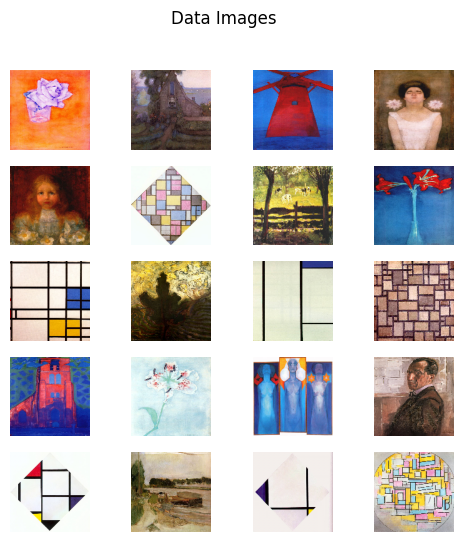

(84, 128, 128, 3)

In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


#Piet_Mondrian128x128.npy
#Gustav_Klimt128x128.npy
#Henri_Matisse128x128.npy 
#Jackson_Pollock128x128.npy 
#Pablo_Picasso128x128.npy
#Amedeo_Modigliani_faces128x128.npy
#Vasiliy_Kandinskiy_geometric128x128.npy
#Pablo_Picasso_faces128x128.npy

    
images_np = np.load('Piet_Mondrian128x128.npy')
    
    
num_samples, img_size, canc, channels = images_np.shape

fig, axes = plt.subplots(5, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    img = images_np[i]
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization
    ax.imshow(img)
    ax.axis("off")
    plt.suptitle("Data Images")

plt.show()

images_np.shape

In [ ]:
"""VARIATIONAL AUTOENCODER  (FIRST VARIANT)"""



using device: cuda
Epoch 2000/2000, Loss: 369.768787

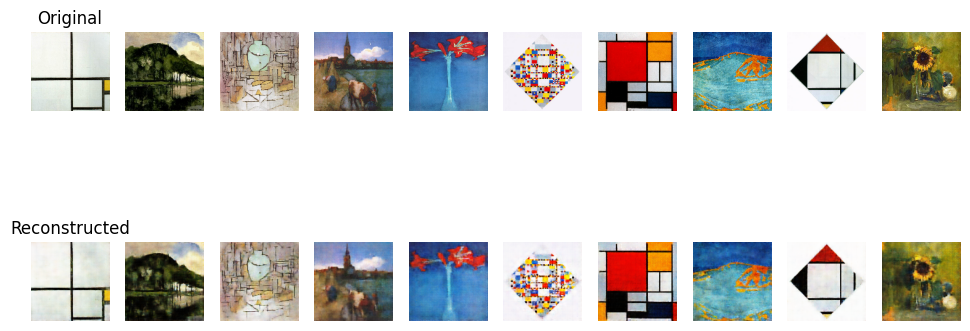

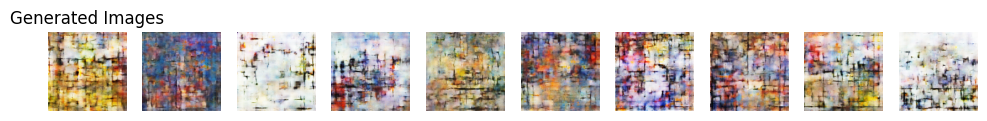

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# --- 1. Define Dataset ---
class ArtDataset(Dataset):
    def __init__(self, images):
        self.images = images.astype(np.float32)  # Normalize to [-1, 1] if needed
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = self.transform(img)
        return img

# --- 2. Define Variational Autoencoder ---
class VariationalAutoencoder(nn.Module):
    def __init__(self, channels=3, latent_dim=128):
        super(VariationalAutoencoder, self).__init__()
        self.latent_dim = latent_dim

        # --- Encoder ---
        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # Compute mean and log variance for latent distribution
        self.fc_mu = nn.Linear(16 * 16 * 16, latent_dim)  # Map to latent space
        self.fc_logvar = nn.Linear(16 * 16 * 16, latent_dim)

        # --- Decoder ---
        self.decoder_fc = nn.Linear(latent_dim, 16 * 16 * 16)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Ensure output is in [0,1] range
        )

    def reparameterize(self, mu, logvar):
        """Reparameterization trick to sample latent vector."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten dynamically
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def decode(self, z):
        x = self.decoder_fc(z).view(-1, 16, 16, 16)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# --- 3. Training Function ---
def train_vae(model, dataloader, epochs=100, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for batch in dataloader:
            optimizer.zero_grad()
            
            recon_batch, mu, logvar = model(batch)
            
            # Reconstruction loss (MSE)
            recon_loss = nn.functional.mse_loss(recon_batch, batch, reduction='sum')

            # KL divergence loss
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

            # Total VAE loss
            loss = recon_loss + kl_loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader.dataset)
        print(f"\rEpoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}", end="", flush=True)

# --- 4. Load and Process Data ---
def load_images(image_array, batch_size=32):
    dataset = ArtDataset(image_array)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# --- 5. Testing Function ---
def test_vae(model, dataloader, num_images):
    model.eval()
    images = next(iter(dataloader))[:num_images]

    with torch.no_grad():
        reconstructed, _, _ = model(images)

    images = images.numpy().transpose(0, 2, 3, 1)
    reconstructed = reconstructed.numpy().transpose(0, 2, 3, 1)

    fig, axes = plt.subplots(2, num_images, figsize=(12, 5))
    for i in range(num_images):
        axes[0, i].imshow(images[i])
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i])
        axes[1, i].axis('off')

    axes[0, 0].set_title("Original")
    axes[1, 0].set_title("Reconstructed")
    plt.show()

# --- 6. Random Image Generation ---
def generate_random_images(model, num_images=5):
    model.eval()
    z = torch.randn(num_images, model.latent_dim)

    with torch.no_grad():
        generated_images = model.decode(z).cpu().detach().numpy().transpose(0, 2, 3, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(12, 5))
    for i in range(num_images):
        axes[i].imshow(generated_images[i])
        axes[i].axis('off')
    axes[0].set_title("Generated Images")
    plt.show()

# --- 7. Main Execution ---
if __name__ == "__main__":
    
    
    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("using device: " + str(device))
    
    # Load images from file
    #images_np = np.load('Amedeo_Modigliani_faces128x128.npy')
    dataloader = load_images(images_np, batch_size=10)

    # Create VAE model
    vae = VariationalAutoencoder(channels=images_np.shape[-1])

    # Train VAE
    train_vae(vae, dataloader, epochs=2000, lr=0.00125)

    # Save the trained model
    torch.save(vae.state_dict(), 'vae.pth')

    # Test VAE
    test_vae(vae, dataloader, num_images=10)

    # Generate new images
    generate_random_images(vae, num_images=10)


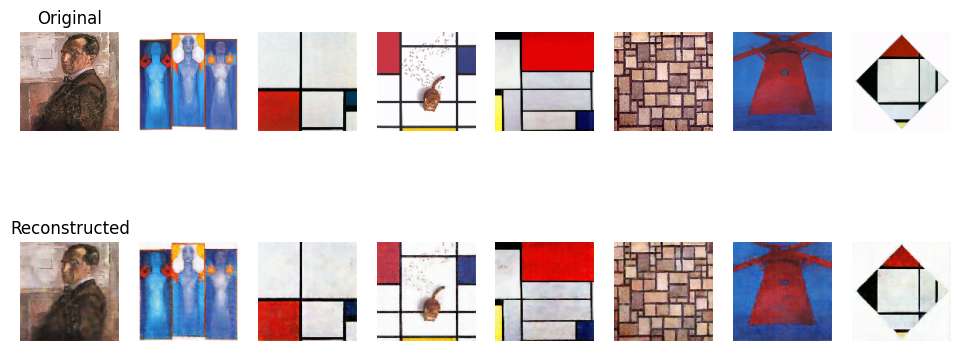

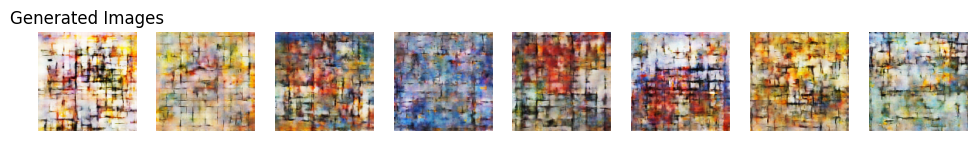

In [16]:
def generate_random_images(model, num_images=5):
    model.eval()
    z = torch.randn(num_images, model.latent_dim)

    with torch.no_grad():
        generated_images = model.decode(z).cpu().detach().numpy().transpose(0, 2, 3, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(12, 5))
    for i in range(num_images):
        axes[i].imshow(generated_images[i])
        axes[i].axis('off')
    axes[0].set_title("Generated Images")
    plt.show()

# Test VAE
test_vae(vae, dataloader, num_images=8)

    # Generate new images
generate_random_images(vae, num_images=8)


In [ ]:
"""VARIATIONAL AUTOENCODER  (SECOND VARIANT by GROK3)"""

In [ ]:
"""LOAD IMAGES IN images npy array"""

In [19]:
#Amedeo_Modigliani_faces128x128.npy
#Henri_Matisse128x128.npy
#Piet_Mondrian_geometric128x128.npy
#Sandro_Botticelli128x128.npy
#Vasiliy_Kandinskiy_geometric128x128.npy

images = np.load("Piet_Mondrian128x128.npy")
#images = images[:200]
images.shape

print('data loaded')

data loaded


using device: cuda
Epoch 2000/2000 - Loss: 22264.6464


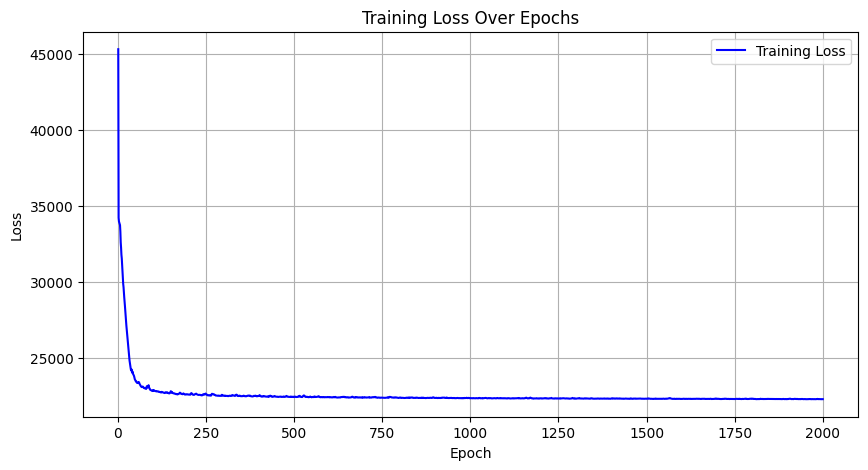

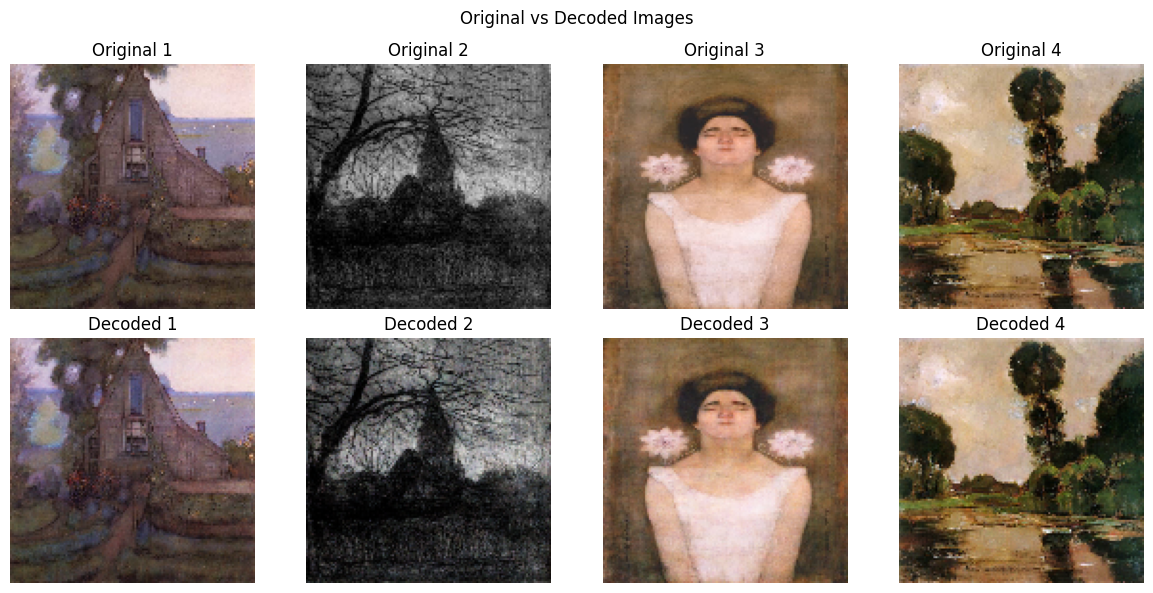

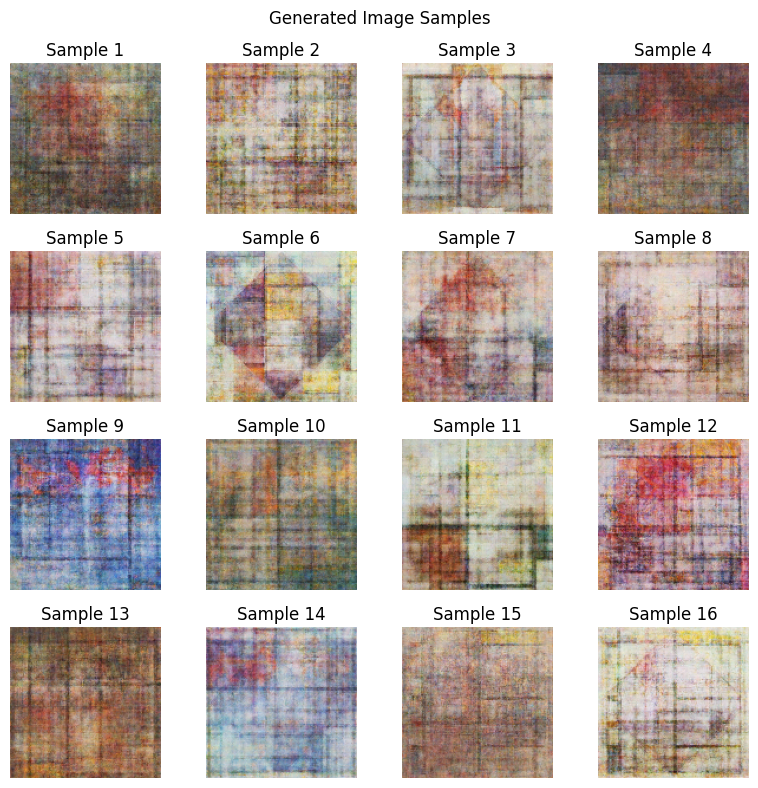

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device: " + str(device))

# Assume images is a NumPy array of shape (num, size, size, 3) with values in [0, 1]
#images = np.random.rand(1000, 28, 28, 3)  # Example: 1000 RGB images of 28x28, already in [0, 1]
num_samples, size, _, channels = images.shape

# Convert to PyTorch tensor and reshape to (num_samples, channels, size, size) for PyTorch
images = torch.FloatTensor(images).permute(0, 3, 1, 2).to(device)  # Shape: (num_samples, 3, size, size)

# Hyperparameters
latent_dim = 2*128  # Size of the latent space
hidden_dim = 256  # Size of hidden layers
learning_rate = 0.5e-3
batch_size = 8
num_epochs = 2000

# VAE Model
class VAE(nn.Module):
    def __init__(self, input_channels, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, hidden_dim, kernel_size=3, stride=2, padding=1),  # Downsample
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Calculate the size after convolutions
        conv_output_size = size // 4  # After two strides of 2
        conv_output_channels = hidden_dim
        self.fc_mu = nn.Linear(hidden_dim * conv_output_size * conv_output_size, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim * conv_output_size * conv_output_size, latent_dim)
        
        self.decoder_input = nn.Linear(latent_dim, hidden_dim * conv_output_size * conv_output_size)
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (hidden_dim, conv_output_size, conv_output_size)),
            nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Output in [0, 1] since images are in [0, 1]
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss Function (using Binary Cross-Entropy since images are in [0, 1])
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Initialize model, optimizer, and data loader
model = VAE(input_channels=channels, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoader
dataset = TensorDataset(images)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training Loop with inline printing
train_losses = []

print("Training...", end='')
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (data,) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    avg_loss = total_loss / len(dataloader.dataset)
    train_losses.append(avg_loss)
    print(f'\rEpoch {epoch + 1}/{num_epochs} - Loss: {avg_loss:.4f}', end='')

print()  # New line after training

# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Original vs Decoded Images
model.eval()
with torch.no_grad():
    # Select a few samples for visualization
    sample_indices = np.random.choice(num_samples, 4, replace=False)  # Select 4 random images
    original_images = images[sample_indices].to(device)
    recon_images, _, _ = model(original_images)

    original_images = original_images.cpu().numpy().transpose(0, 2, 3, 1)  # Shape: (4, size, size, 3)
    recon_images = recon_images.cpu().numpy().transpose(0, 2, 3, 1)  # Shape: (4, size, size, 3)

    plt.figure(figsize=(12, 6))
    for i in range(4):
        # Original Image
        plt.subplot(2, 4, i + 1)
        plt.imshow(original_images[i])
        plt.title(f'Original {i+1}')
        plt.axis('off')

        # Decoded (Reconstructed) Image
        plt.subplot(2, 4, i + 5)
        plt.imshow(recon_images[i])
        plt.title(f'Decoded {i+1}')
        plt.axis('off')

    plt.suptitle('Original vs Decoded Images')
    plt.tight_layout()
    plt.show()

# Generate New Images
model.eval()
with torch.no_grad():
    # Sample from latent space
    z = torch.randn(16, latent_dim).to(device)  # Generate 16 new samples
    generated_images = model.decode(z).cpu().numpy()

    # Reshape generated images for plotting
    generated_images = generated_images.transpose(0, 2, 3, 1)  # Shape: (16, size, size, 3)

    # Plot Generated Samples
    plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.title(f'Sample {i+1}')
    plt.suptitle('Generated Image Samples')
    plt.tight_layout()
    plt.show()

In [ ]:
save trained VAE 

In [11]:
# Save the model and optimizer state
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'loss': train_losses,
}, 'vae_checkpoint.pth')

print("model saved")

model saved


In [ ]:
Continue training 


Epoch 4000/4000 - Loss: 24744.5305training...


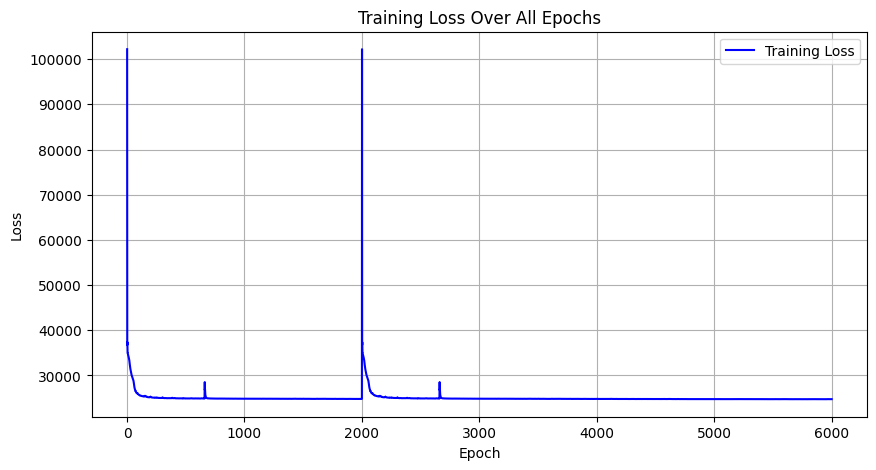

In [12]:
# Load and Continue Training
print("\nLoading checkpoint and continuing training...", end='')
checkpoint = torch.load('vae_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
starting_epoch = checkpoint['epoch']
train_losses.extend(checkpoint['loss'])  # Append previous losses

# Continue training for additional epochs
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (data,) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    avg_loss = total_loss / len(dataloader.dataset)
    train_losses.append(avg_loss)
    print(f'\rEpoch {starting_epoch + epoch + 1}/{starting_epoch + num_epochs} - Loss: {avg_loss:.4f}', end='')

print()  # New line after continued training

# Plot Training Loss (both initial and additional)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
plt.title('Training Loss Over All Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Generate New Images
model.eval()
with torch.no_grad():
    # Sample from latent space
    z = torch.randn(16, latent_dim).to(device)  # Generate 16 new samples
    generated_images = model.decode(z).cpu().numpy()

    # Reshape generated images for plotting
    generated_images = generated_images.transpose(0, 2, 3, 1)  # Shape: (16, size, size, 3)

    # Plot Generated Samples
    plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.title(f'Sample {i+1}')
    plt.suptitle('Generated Image Samples')
    plt.tight_layout()
    plt.show()

In [ ]:
"""VARIATIONAL AUTOENCODER  (THIRD VARIANT by DEEPSEEK)"""

In [21]:
"""LOAD IMAGES"""

#Amedeo_Modigliani_faces128x128.npy
#Henri_Matisse128x128.npy
#Piet_Mondrian_geometric128x128.npy
#Sandro_Botticelli128x128.npy
#Vasiliy_Kandinskiy_geometric128x128.npy

images = np.load("Piet_Mondrian128x128.npy")

#images = images[:200]
images.shape

print('data loaded')


data loaded


using device: cuda
Training...
Epoch 2000/2000 - Loss: 22294.3261

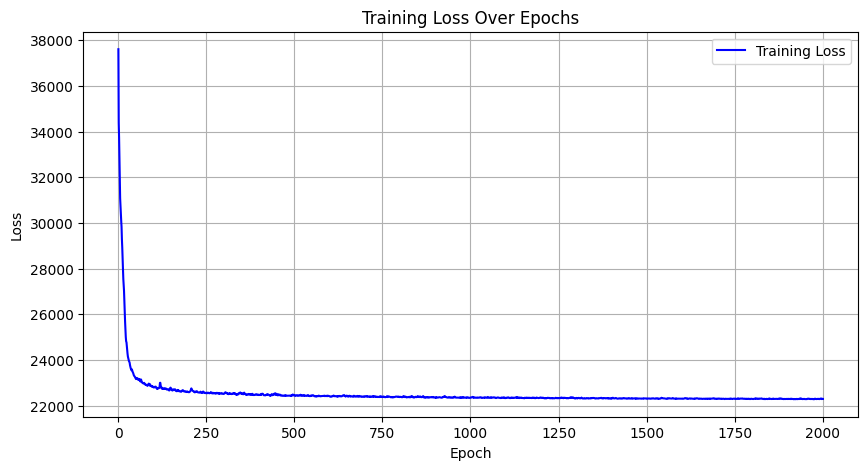

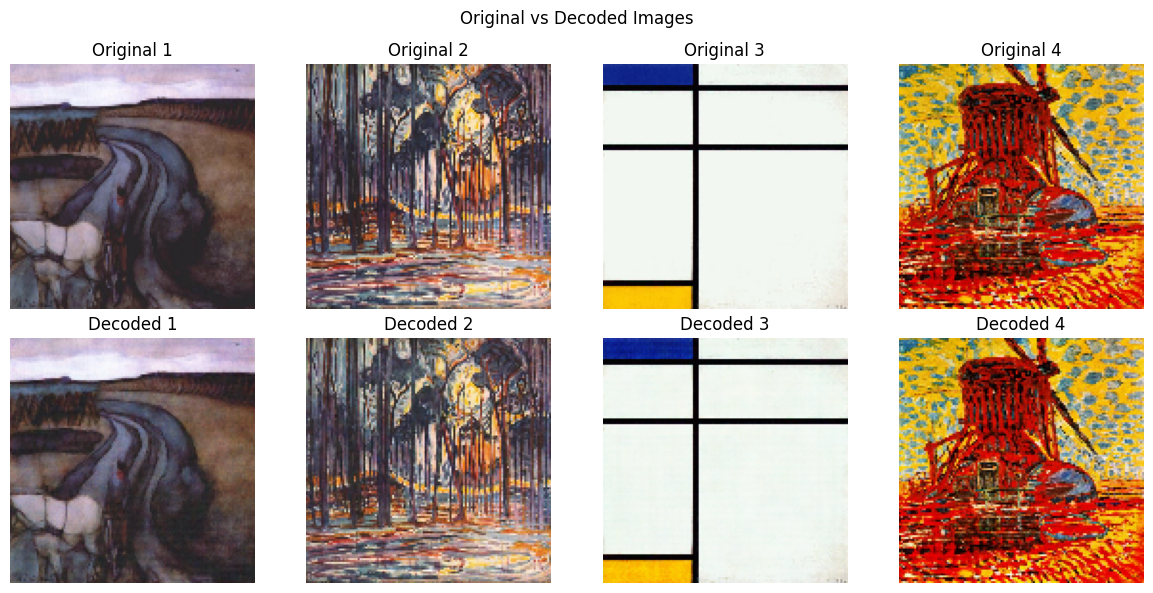

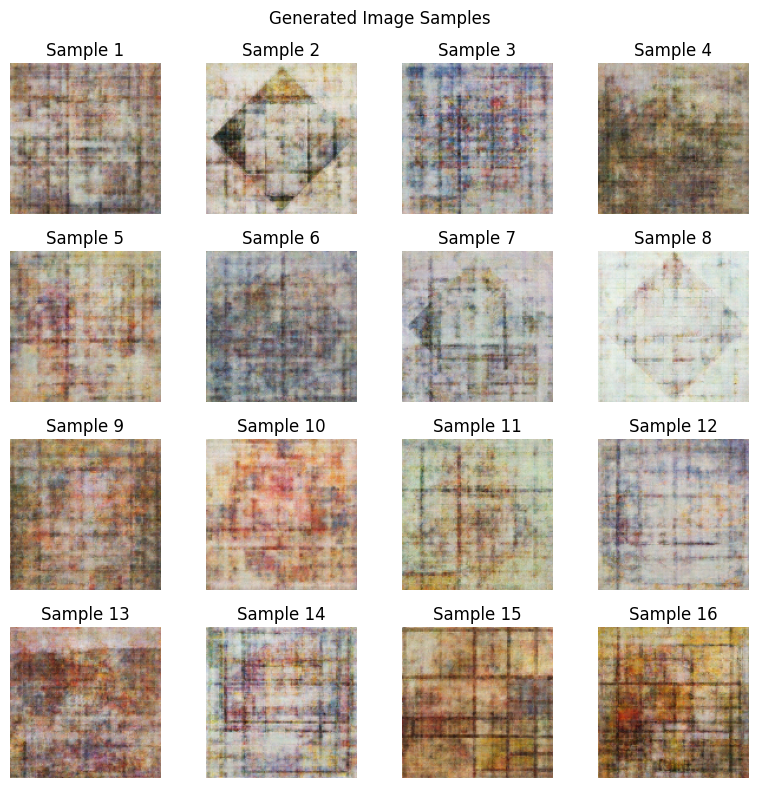

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device: " + str(device))

# Load images from .npy file
#images = np.load("Amedeo_Modigliani_faces128x128.npy")  # Shape: (num_samples, size, size, 3)
num_samples, size, _, channels = images.shape

# Convert to PyTorch tensor and reshape to (num_samples, channels, size, size)
images = torch.FloatTensor(images).permute(0, 3, 1, 2).to(device)  # Shape: (num_samples, 3, size, size)

# Hyperparameters
latent_dim = 2*256  # Size of the latent space
hidden_dim = 256  # Size of hidden layers
learning_rate = 0.5e-3
batch_size = 8
num_epochs = 2000

# VAE Model
class VAE(nn.Module):
    def __init__(self, input_channels, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, hidden_dim, kernel_size=3, stride=2, padding=1),  # Downsample
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Calculate the size after convolutions
        conv_output_size = size // 4  # After two strides of 2
        conv_output_channels = hidden_dim
        self.fc_mu = nn.Linear(hidden_dim * conv_output_size * conv_output_size, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim * conv_output_size * conv_output_size, latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, hidden_dim * conv_output_size * conv_output_size)
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (hidden_dim, conv_output_size, conv_output_size)),
            nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Output in [0, 1]
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss Function (Binary Cross-Entropy + KL Divergence)
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Initialize model, optimizer, and data loader
model = VAE(input_channels=channels, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoader
dataset = TensorDataset(images, images)  # Use images as both input and target
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training Loop
train_losses = []

print("Training...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, target, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    avg_loss = total_loss / len(dataloader.dataset)
    train_losses.append(avg_loss)
    print(f'\rEpoch {epoch + 1}/{num_epochs} - Loss: {avg_loss:.4f}',end = "")

# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Original vs Decoded Images
model.eval()
with torch.no_grad():
    # Select a few samples for visualization
    sample_indices = np.random.choice(num_samples, 4, replace=False)  # Select 4 random images
    original_images = images[sample_indices].to(device)
    recon_images, _, _ = model(original_images)

    original_images = original_images.cpu().numpy().transpose(0, 2, 3, 1)  # Shape: (4, size, size, 3)
    recon_images = recon_images.cpu().numpy().transpose(0, 2, 3, 1)  # Shape: (4, size, size, 3)

    plt.figure(figsize=(12, 6))
    for i in range(4):
        # Original Image
        plt.subplot(2, 4, i + 1)
        plt.imshow(original_images[i])
        plt.title(f'Original {i+1}')
        plt.axis('off')

        # Decoded (Reconstructed) Image
        plt.subplot(2, 4, i + 5)
        plt.imshow(recon_images[i])
        plt.title(f'Decoded {i+1}')
        plt.axis('off')

    plt.suptitle('Original vs Decoded Images')
    plt.tight_layout()
    plt.show()

# Generate New Images
model.eval()
with torch.no_grad():
    # Sample from latent space
    z = torch.randn(16, latent_dim).to(device)  # Generate 16 new samples
    generated_images = model.decode(z).cpu().numpy()

    # Reshape generated images for plotting
    generated_images = generated_images.transpose(0, 2, 3, 1)  # Shape: (16, size, size, 3)

    # Plot Generated Samples
    plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.title(f'Sample {i+1}')
    plt.suptitle('Generated Image Samples')
    plt.tight_layout()
    plt.show()